In [74]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import randint

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV


import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [75]:
file_path = r'/Users/joelsabiti/Desktop/practicals/cereals/data.csv'

df = pd.read_csv(file_path)

In [76]:
print(df.dtypes)

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [77]:
duplicates = df[df.duplicated()]
print("Duplicated Rows:")
print(duplicates)

Duplicated Rows:
Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud]
Index: []


In [78]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

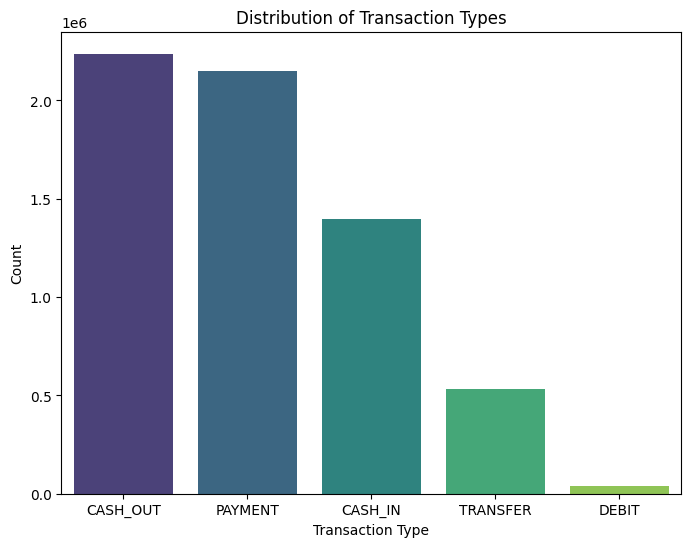

In [79]:
type_counts = df['type'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette='viridis')
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

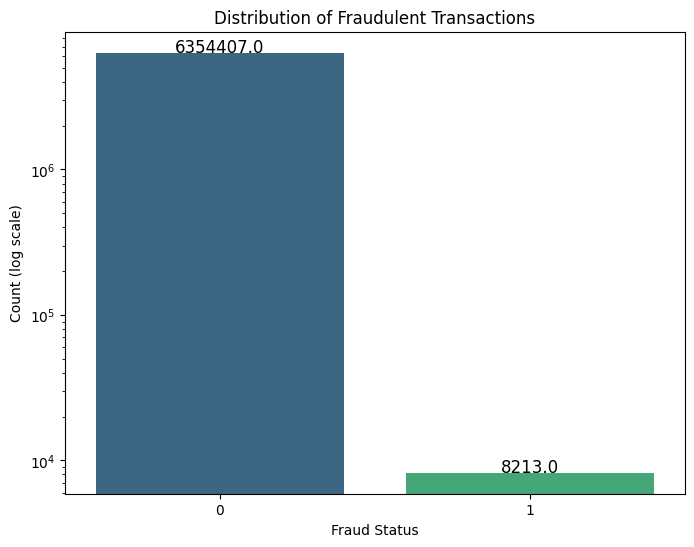

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
fraud_counts = df['isFraud'].value_counts()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black')
ax.set_yscale('log')
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Fraud Status')
plt.ylabel('Count (log scale)')
plt.show()

In [81]:
result = df.groupby('isFraud')['type'].value_counts()
print(result)

isFraud  type    
0        CASH_OUT    2233384
         PAYMENT     2151495
         CASH_IN     1399284
         TRANSFER     528812
         DEBIT         41432
1        CASH_OUT       4116
         TRANSFER       4097
Name: count, dtype: int64


In [82]:

len(df['nameOrig'].unique())

6353307

In [83]:
len(df['nameDest'].unique())

2722362

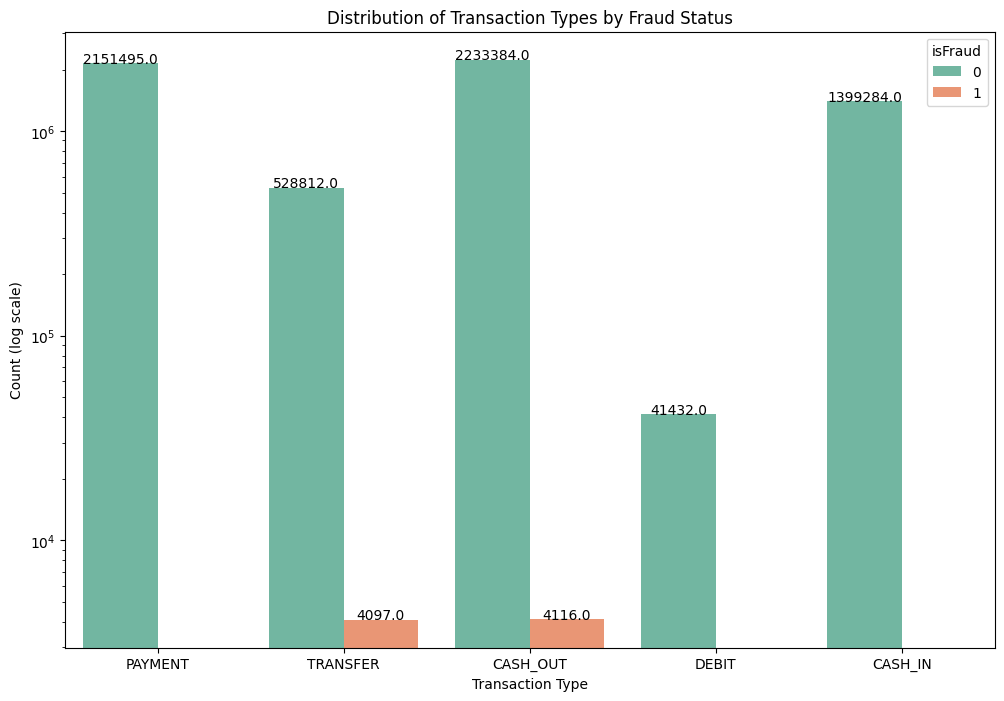

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

df['isFraud'] = df['isFraud'].astype(str)

plt.figure(figsize=(12, 8))

# Countplot for 'type' column with hue='isFraud' and logarithmic scale
ax = sns.countplot(x='type', hue='isFraud', data=df, palette='Set2')

# Adding value annotations on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black')

# Set the y-axis to logarithmic scale
plt.yscale('log')

plt.title('Distribution of Transaction Types by Fraud Status')
plt.xlabel('Transaction Type')
plt.ylabel('Count (log scale)')

plt.show()
 

In [85]:
df['type'] = df['type'].replace(['CASH_IN','PAYMENT','DEBIT'], 'OTHER')

In [86]:
df.replace(to_replace = ['TRANSFER', 'CASH_OUT', 'OTHER'], value = [1,2,3],inplace = True)

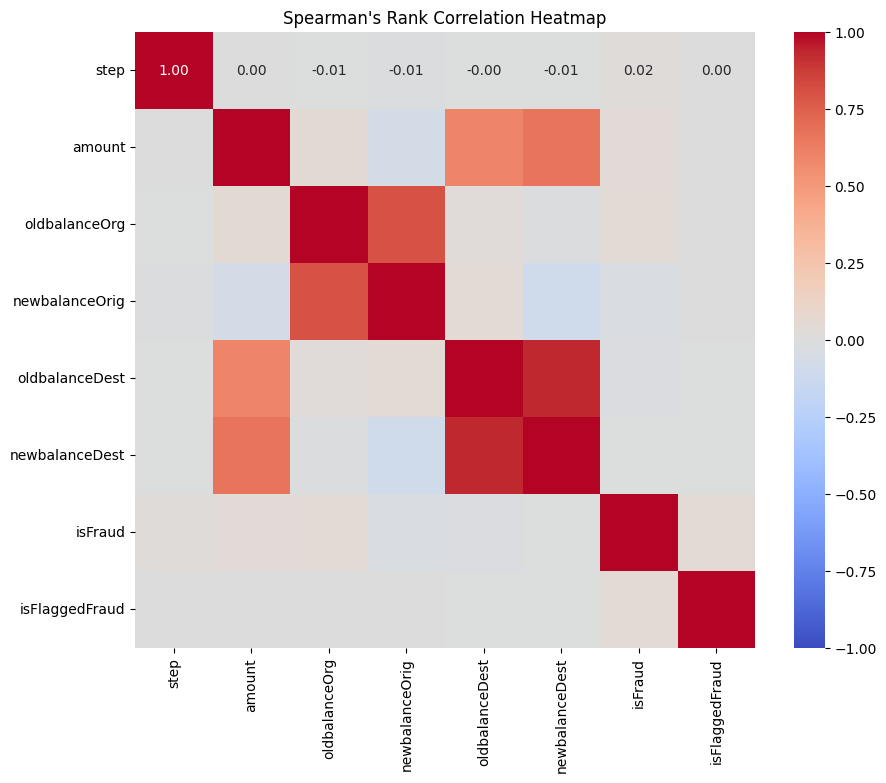

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
cols_to_drop=['nameDest','nameOrig','type']
df=df.drop(cols_to_drop, axis = 1)
spearman_corr_matrix = df.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, mask=spearman_corr_matrix.isna())
plt.title("Spearman's Rank Correlation Heatmap")
plt.show()


In [88]:
df['step'] = df['step'] / 24
df['step'] = df['step'].round().astype(int)
df['day'] = df['step'] % 7
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['day'] = df['day'].map(day_mapping)

In [89]:
custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ordinal_encoder = OrdinalEncoder(categories=[custom_order])
df['day'] = ordinal_encoder.fit_transform(df[['day']])

In [90]:
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
0,0,9839.64,170136.00,160296.36,0.00,0.00,0,0,0.0
1,0,1864.28,21249.00,19384.72,0.00,0.00,0,0,0.0
2,0,181.00,181.00,0.00,0.00,0.00,1,0,0.0
3,0,181.00,181.00,0.00,21182.00,0.00,1,0,0.0
4,0,11668.14,41554.00,29885.86,0.00,0.00,0,0,0.0
...,...,...,...,...,...,...,...,...,...
6362615,31,339682.13,339682.13,0.00,0.00,339682.13,1,0,3.0
6362616,31,6311409.28,6311409.28,0.00,0.00,0.00,1,0,3.0
6362617,31,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,3.0
6362618,31,850002.52,850002.52,0.00,0.00,0.00,1,0,3.0


In [91]:
cols_to_drop=['oldbalanceDest','newbalanceDest','newbalanceOrig','isFlaggedFraud','step']
df.drop(cols_to_drop, axis=1, inplace=True)

In [92]:
df['isFraud'] = df['isFraud'].astype(int)

# Models Without resampling

## XG BOOST Classifier

In [65]:
from sklearn.metrics import f1_score
X = df.drop('isFraud', axis=1) 
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = RobustScaler()
scaled_columns = scaler.fit_transform(X_train[['amount','oldbalanceOrg']])

X_train_scaled = X_train.copy()
X_train_scaled[['amount','oldbalanceOrg']] = scaled_columns
scaled_columns = scaler.fit_transform(X_test[['amount','oldbalanceOrg']])
X_test_scaled = X_test.copy()
X_test_scaled[['amount','oldbalanceOrg']] = scaled_columns
X_train = X_train_scaled
X_test = X_test_scaled
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

report = classification_report(y_test, y_pred,digits=6)
print("Classification Report:\n", report)

f1_minority = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score for Minority Class: {f1_minority}")


Confusion Matrix:
[[1270815      89]
 [    901     719]]
Classification Report:
               precision    recall  f1-score   support

           0   0.999292  0.999930  0.999611   1270904
           1   0.889851  0.443827  0.592257      1620

    accuracy                       0.999222   1272524
   macro avg   0.944571  0.721879  0.795934   1272524
weighted avg   0.999152  0.999222  0.999092   1272524

F1 Score for Minority Class: 0.5922570016474464


## Random Forest 

In [67]:
from sklearn.ensemble import RandomForestClassifier
X = df.drop('isFraud', axis=1) 
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = RobustScaler()
scaled_columns = scaler.fit_transform(X_train[['amount','oldbalanceOrg']])
X_train_scaled = X_train.copy()
X_train_scaled[['amount','oldbalanceOrg']] = scaled_columns
scaled_columns = scaler.fit_transform(X_test[['amount','oldbalanceOrg']])
X_test_scaled = X_test.copy()
X_test_scaled[['amount','oldbalanceOrg']] = scaled_columns
X_train = X_train_scaled
X_test = X_test_scaled
model =RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nRandom Forest Results using SMOTE:")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

report = classification_report(y_test, y_pred,digits=6)
print("Classification Report:\n", report)

f1_minority = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score for Minority Class: {f1_minority}")


Random Forest Results using SMOTE:
Confusion Matrix:
[[1270762     142]
 [    703     917]]
Classification Report:
               precision    recall  f1-score   support

           0   0.999447  0.999888  0.999668   1270904
           1   0.865911  0.566049  0.684584      1620

    accuracy                       0.999336   1272524
   macro avg   0.932679  0.782969  0.842126   1272524
weighted avg   0.999277  0.999336  0.999267   1272524

F1 Score for Minority Class: 0.6845837999253453


## Decision Tree Classifier 

In [68]:
X = df.drop('isFraud', axis=1) 
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = RobustScaler()
scaled_columns = scaler.fit_transform(X_train[['amount','oldbalanceOrg']])
X_train_scaled = X_train.copy()
X_train_scaled[['amount','oldbalanceOrg']] = scaled_columns
scaled_columns = scaler.fit_transform(X_test[['amount','oldbalanceOrg']])
X_test_scaled = X_test.copy()
X_test_scaled[['amount','oldbalanceOrg']] = scaled_columns
X_train = X_train_scaled
X_test = X_test_scaled
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nDecision Trees using SMOTE TOMEK:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred,digits=4))
f1_minority = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score for Minority Class: {f1_minority}")


Decision Trees using SMOTE TOMEK:
Confusion Matrix:
[[1270436     468]
 [    563    1057]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9996    0.9996   1270904
           1     0.6931    0.6525    0.6722      1620

    accuracy                         0.9992   1272524
   macro avg     0.8463    0.8261    0.8359   1272524
weighted avg     0.9992    0.9992    0.9992   1272524

F1 Score for Minority Class: 0.6721780604133545


## KNN 

In [69]:
X = df.drop('isFraud', axis=1) 
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = RobustScaler()
scaled_columns = scaler.fit_transform(X_train[['amount','oldbalanceOrg']])
X_train_scaled = X_train.copy()
X_train_scaled[['amount','oldbalanceOrg']] = scaled_columns
scaled_columns = scaler.fit_transform(X_test[['amount','oldbalanceOrg']])
X_test_scaled = X_test.copy()
X_test_scaled[['amount','oldbalanceOrg']] = scaled_columns
X_train = X_train_scaled
X_test = X_test_scaled
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nKNN Results using SMOTE TOMEK:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred,digits=4))
f1_minority = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score for Minority Class: {f1_minority}")


KNN Results using SMOTE TOMEK:
Confusion Matrix:
[[1270753     151]
 [    864     756]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9993    0.9999    0.9996   1270904
           1     0.8335    0.4667    0.5983      1620

    accuracy                         0.9992   1272524
   macro avg     0.9164    0.7333    0.7990   1272524
weighted avg     0.9991    0.9992    0.9991   1272524

F1 Score for Minority Class: 0.5983379501385042


# Models with SMOTE and SMOTE TOMEK Links

## XGB with smote

In [38]:
from sklearn.metrics import f1_score
smt = SMOTE(random_state=42)
X = df.drop('isFraud', axis=1) 
y = df['isFraud']
X,y = smt.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = RobustScaler()
scaled_columns = scaler.fit_transform(X_train[['amount','oldbalanceOrg']])
X_train_scaled = X_train.copy()
X_train_scaled[['amount','oldbalanceOrg']] = scaled_columns
scaled_columns = scaler.fit_transform(X_test[['amount','oldbalanceOrg']])
X_test_scaled = X_test.copy()
X_test_scaled[['amount','oldbalanceOrg']] = scaled_columns
X_train = X_train_scaled
X_test = X_test_scaled
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

report = classification_report(y_test, y_pred,digits=6)
print("Classification Report:\n", report)

f1_minority = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score for Minority Class: {f1_minority}")


Confusion Matrix:
[[1268827    2010]
 [   2109 1268817]]
Classification Report:
               precision    recall  f1-score   support

           0   0.998341  0.998418  0.998379   1270837
           1   0.998418  0.998341  0.998379   1270926

    accuracy                       0.998379   2541763
   macro avg   0.998379  0.998379  0.998379   2541763
weighted avg   0.998379  0.998379  0.998379   2541763

F1 Score for Minority Class: 0.9983794648811272


## XGB with smote and TOMEK Links

In [39]:
smt = SMOTETomek(random_state=2)
X = df.drop('isFraud', axis=1) 
y = df['isFraud']
X,y = smt.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
scaled_columns = scaler.fit_transform(X_train[['amount','oldbalanceOrg']])
X_train_scaled = X_train.copy()
X_train_scaled[['amount','oldbalanceOrg']] = scaled_columns
scaled_columns = scaler.fit_transform(X_test[['amount','oldbalanceOrg']])
X_test_scaled = X_test.copy()
X_test_scaled[['amount','oldbalanceOrg']] = scaled_columns
X_train = X_train_scaled
X_test = X_test_scaled
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

report = classification_report(y_test, y_pred,digits=6)
print("Classification Report:\n", report)

f1_minority = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score for Minority Class: {f1_minority}")

Confusion Matrix:
[[1266621    1741]
 [   1459 1267541]]
Classification Report:
               precision    recall  f1-score   support

           0   0.998849  0.998627  0.998738   1268362
           1   0.998628  0.998850  0.998739   1269000

    accuracy                       0.998739   2537362
   macro avg   0.998739  0.998739  0.998739   2537362
weighted avg   0.998739  0.998739  0.998739   2537362

F1 Score for Minority Class: 0.9987393047738589


## RANDOM FOREST

### Random Forest with SMOTE

In [16]:
from sklearn.ensemble import RandomForestClassifier
smt = SMOTE(random_state=42)
X = df.drop('isFraud', axis=1) 
y = df['isFraud']

X, y = smt.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
scaled_columns = scaler.fit_transform(X_train[['amount','oldbalanceOrg']])
X_train_scaled = X_train.copy()
X_train_scaled[['amount','oldbalanceOrg']] = scaled_columns
scaled_columns = scaler.fit_transform(X_test[['amount','oldbalanceOrg']])
X_test_scaled = X_test.copy()
X_test_scaled[['amount','oldbalanceOrg']] = scaled_columns
X_train = X_train_scaled
X_test = X_test_scaled
model =RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nRandom Forest Results using SMOTE:")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

report = classification_report(y_test, y_pred,digits=6)
print("Classification Report:\n", report)

f1_minority = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score for Minority Class: {f1_minority}")


Random Forest Results using SMOTE:
Confusion Matrix:
[[1270370     467]
 [  11145 1259781]]
Classification Report:
               precision    recall  f1-score   support

           0   0.991303  0.999633  0.995450   1270837
           1   0.999629  0.991231  0.995412   1270926

    accuracy                       0.995432   2541763
   macro avg   0.995466  0.995432  0.995431   2541763
weighted avg   0.995466  0.995432  0.995431   2541763

F1 Score for Minority Class: 0.9954124054687667


### Random Forest with SMOTE and TOMEK Links

In [70]:
from sklearn.ensemble import RandomForestClassifier
smt = SMOTETomek(random_state=2)
X = df.drop('isFraud', axis=1) 
y = df['isFraud']
X, y = smt.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = RobustScaler()
scaled_columns = scaler.fit_transform(X_train[['amount','oldbalanceOrg']])
X_train_scaled = X_train.copy()
X_train_scaled[['amount','oldbalanceOrg']] = scaled_columns
scaled_columns = scaler.fit_transform(X_test[['amount','oldbalanceOrg']])
X_test_scaled = X_test.copy()
X_test_scaled[['amount','oldbalanceOrg']] = scaled_columns
X_train = X_train_scaled
X_test = X_test_scaled
model =RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred =model.predict(X_test)
print("\nRandom Forest Results using SMOTE:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred,digits=4))
f1_minority = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score for Minority Class: {f1_minority}")


Random Forest Results using SMOTE:
Confusion Matrix:
[[1266777     677]
 [ 203368 1066466]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8617    0.9995    0.9255   1267454
           1     0.9994    0.8398    0.9127   1269834

    accuracy                         0.9196   2537288
   macro avg     0.9305    0.9197    0.9191   2537288
weighted avg     0.9306    0.9196    0.9191   2537288

F1 Score for Minority Class: 0.9126884860227551


## Decision Trees

### Decision Trees with SMOTE and TOMEK Links

In [86]:
smt = SMOTETomek(random_state=2)
X = df.drop('isFraud', axis=1) 
y = df['isFraud']
X, y = smt.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
scaled_columns = scaler.fit_transform(X_train[['amount','oldbalanceOrg']])
X_train_scaled = X_train.copy()
X_train_scaled[['amount','oldbalanceOrg']] = scaled_columns
scaled_columns = scaler.fit_transform(X_test[['amount','oldbalanceOrg']])
X_test_scaled = X_test.copy()
X_test_scaled[['amount','oldbalanceOrg']] = scaled_columns
X_train = X_train_scaled
X_test = X_test_scaled
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nDecision Trees using SMOTE TOMEK:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred,digits=4))


f1_minority = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score for Minority Class: {f1_minority}")


Decision Trees using SMOTE TOMEK:
Confusion Matrix:
[[1267694     668]
 [  26444 1242556]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9796    0.9995    0.9894   1268362
           1     0.9995    0.9792    0.9892   1269000

    accuracy                         0.9893   2537362
   macro avg     0.9895    0.9893    0.9893   2537362
weighted avg     0.9895    0.9893    0.9893   2537362

F1 Score for Minority Class: 0.9892079687161655


### Decision Trees with SMOTE

In [87]:
smt = SMOTE(random_state=42)
X = df.drop('isFraud', axis=1) 
y = df['isFraud']
X, y = smt.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = RobustScaler()
scaled_columns = scaler.fit_transform(X_train[['amount','oldbalanceOrg']])
X_train_scaled = X_train.copy()
X_train_scaled[['amount','oldbalanceOrg']] = scaled_columns
scaled_columns = scaler.fit_transform(X_test[['amount','oldbalanceOrg']])
X_test_scaled = X_test.copy()
X_test_scaled[['amount','oldbalanceOrg']] = scaled_columns
X_train = X_train_scaled
X_test = X_test_scaled
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nDecision Trees Results using SMOTE:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred,digits=4))



f1_minority = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score for Minority Class: {f1_minority}")


Decision Trees Results using SMOTE:
Confusion Matrix:
[[1270176     661]
 [  44911 1226015]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9658    0.9995    0.9824   1270837
           1     0.9995    0.9647    0.9818   1270926

    accuracy                         0.9821   2541763
   macro avg     0.9827    0.9821    0.9821   2541763
weighted avg     0.9827    0.9821    0.9821   2541763

F1 Score for Minority Class: 0.9817536981472629


## KNN

### KNN with SMOTE and TOMEK Links

In [88]:
smt = SMOTETomek(random_state=2)
X = df.drop('isFraud', axis=1) 
y = df['isFraud']

X, y = smt.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
scaled_columns = scaler.fit_transform(X_train[['amount','oldbalanceOrg']])
X_train_scaled = X_train.copy()
X_train_scaled[['amount','oldbalanceOrg']] = scaled_columns
scaled_columns = scaler.fit_transform(X_test[['amount','oldbalanceOrg']])
X_test_scaled = X_test.copy()
X_test_scaled[['amount','oldbalanceOrg']] = scaled_columns
X_train = X_train_scaled
X_test = X_test_scaled
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nKNN Results using SMOTE TOMEK:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred,digits=4))



f1_minority = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score for Minority Class: {f1_minority}")


KNN Results using SMOTE TOMEK:
Confusion Matrix:
[[1265839    2523]
 [  23521 1245479]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9818    0.9980    0.9898   1268362
           1     0.9980    0.9815    0.9897   1269000

    accuracy                         0.9897   2537362
   macro avg     0.9899    0.9897    0.9897   2537362
weighted avg     0.9899    0.9897    0.9897   2537362

F1 Score for Minority Class: 0.9896527694455547


### KNN with SMOTE

In [89]:
smt = SMOTE(random_state=2)
X = df.drop('isFraud', axis=1) 
y = df['isFraud']

X, y = smt.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
scaled_columns = scaler.fit_transform(X_train[['amount','oldbalanceOrg']])
X_train_scaled = X_train.copy()
X_train_scaled[['amount','oldbalanceOrg'] = scaled_columns
scaled_columns = scaler.fit_transform(X_test[['amount','oldbalanceOrg']])
X_test_scaled = X_test.copy()
X_test_scaled[['amount','oldbalanceOrg']] = scaled_columns
X_train = X_train_scaled
X_test = X_test_scaled
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nKNN Results using SMOTE:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred,digits=4))



f1_minority = f1_score(y_test, y_pred, average='binary')
print(f"F1 Score for Minority Class: {f1_minority}")


KNN Results using SMOTE:
Confusion Matrix:
[[1268197    2640]
 [  23975 1246951]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9814    0.9979    0.9896   1270837
           1     0.9979    0.9811    0.9894   1270926

    accuracy                         0.9895   2541763
   macro avg     0.9897    0.9895    0.9895   2541763
weighted avg     0.9897    0.9895    0.9895   2541763

F1 Score for Minority Class: 0.989440658404605
